# FIFA Players Attribute Analysis
* FIFA database contains player information with detailed attributes.
* Certain attributes may be correlated to other attirbutes. Created heat map to show correlation between stat points.
* A player's overall is determined by a formulation of all the stat points. Used a nonlinear regression model to predict player values.
* Some stat points are more important than others when calculating overall player value. Weights were assigned to stat points to determine its importance.

In [9]:
!pip install eli5


  Created wheel for tabulate: filename=tabulate-0.8.3-cp37-none-any.whl size=23385 sha256=03815646f88ff4f949a099e7ace1906ce7246b31cf0167ceedde0bca9c92d4cf
  Stored in directory: C:\Users\detba\AppData\Local\pip\Cache\wheels\2b\67\89\414471314a2d15de625d184d8be6d38a03ae1e983dbda91e84
Successfully built tabulate


In [10]:
import math
import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime, time
import seaborn as sns
import cufflinks as cf
import io
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import xgboost as xgb
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV

Using TensorFlow backend.


### Read Data
* Display first 5 rows of data 

In [11]:
#Read CSV
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [12]:
#Take a look at data
df.sort_values(by=['Overall'], ascending=False, inplace = True)
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,â¬226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,â¬127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,â¬228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,â¬138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,â¬196.4M


### Data Cleaning
* Keep only columns relevant to skill and stat points
* Separate goalkeepers from outfield players

In [13]:
# Remove GK from position 
df = df[df.Position != 'GK']

In [14]:
# Drop unwanted columns
df1 = df.drop(['Unnamed: 0', 'ID', 'Name', 'Photo', 'Nationality', 'Flag', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],axis=1)
df1.head()

,Age,Overall,Potential,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,31,94,94,4.0,4.0,84.0,95.0,70.0,90.0,86.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,33,94,94,4.0,5.0,84.0,94.0,89.0,81.0,87.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,26,92,93,5.0,5.0,79.0,87.0,62.0,84.0,84.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
4,27,91,92,5.0,4.0,93.0,82.0,55.0,92.0,82.0,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
5,27,91,91,4.0,4.0,81.0,84.0,61.0,89.0,80.0,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0


### Machine Learning
* Split dataset for machine training.
* Used SKLearn and XGBoost libraries to calculate r-squared value and mean squared error value.
* Used nonlinear regression to predict player rating based on skill points.

In [15]:
#Split ID as a Target value
target = df1.Overall
df2 = df1.drop(['Overall'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.2)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(3237, 33) (12945, 33)
(3237,) (12945,)


In [16]:
#Applying Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [176]:
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

r2 score: 0.9279536483920702
RMSE : 1.8072927822417257


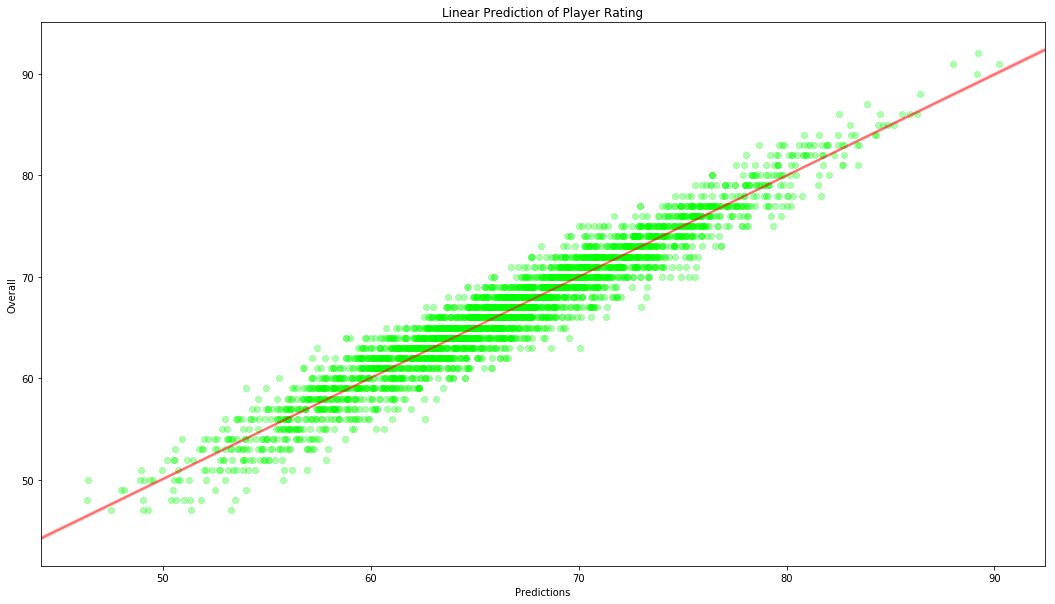

In [177]:
#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_test,scatter_kws={'alpha':0.3,'color':'lime'},line_kws={'color':'red','alpha':0.5})
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

### More Machine Learning

In [178]:
#Split data into testing and training sample sizes for machine learning
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
X = df1.iloc[:,2:]
y = df1.loc[:,'Overall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 11293
Test dataset sample size: 4841


In [179]:
#Evaluate R-squared and mean squared error


regbgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

regbgb.fit(X_train,y_train)
p = regbgb.predict(X_test)
r2 = r2_score(y_test, p)
err = mean_squared_error(y_test, p)

print ( 'r2', r2)
print ( 'err', err)

r2 0.9820278584827429
err 0.8420286490150722


In [180]:
df_ml = pd.DataFrame({'Predicted Value': p,'Overall Value': y_test}, index= X_test.index).sort_index()
df_ml2 = df.loc[X_test.index]
df_ml3 = pd.merge(df_ml, df_ml2, left_index=True, right_index=True)
df_ml3[['Overall Value','Predicted Value']].iplot(kind='line', xTitle='Player ID', yTitle='Overall Value', world_readable=True)

### Data Correlation
* Create correlation matrix with desired attribute columns.
* Generate a correlation heatmap with seaborn library.

In [181]:
#Creating correlation reference
corr = df1[df1.columns[:]].corr()

In [182]:
fig = corr.iplot(kind='heatmap', colorscale='RdBu')


### Weight
* Assigned weights to stat points based on how much it affects overall rating

In [183]:
#Find which stat points most affect the overall rating
weights = pd.Series(100*regbgb.feature_importances_,index=X_train.columns).sort_values()
weights.iplot(kind='bar', yTitle='%', world_readable=True, title='Stat Point Weight')